In [87]:
import pandas as pd
import geopandas as gpd
import os
import osmnx as ox
import rasterio
from rasterio.plot import show as Show
from rasterio import mask as mask
import pylab as plt
data = os.getenv('data')
from rasterstats import point_query
import shapely
from shapely import wkt
import warnings
warnings.filterwarnings('ignore')

In [252]:
lst = ['hi','this','is','a','sentence']
lst2 = ['hi']

'_'.join(lst2)

'hi'

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  # natural earth dataset used for country outlines

In [39]:
landslide_pth = data+'/energy/LS_RF_Mean_1980-2018.tif'  # ARUP landslide layer downloaded from DDH (rainfall trigger)

## Landslide risk analysis for points of interest
This notebook demonstrates a workflow to:
* Import the landslide layer
* Get POI data from OpenStreetMap
* Get the landslide risk at each location
* Compare the average landslide risk for the POIs across regions

We use hospitals in Italy for this demo. For a larger number of POIs we could re-run it with schools. Can be run for any European country and POI type. Suggested extensions welcome.

#### 1. Landslide data cropped to Italy borders

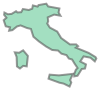

In [245]:
country = 'Italy'
geom = world.geometry[world.name == country].reset_index(drop=True)[0]
geom

In [246]:
with rasterio.open(landslide_pth) as src:
    maskData, maskTransform = mask.mask(src, [geom], crop=True, nodata=src.nodatavals[0])

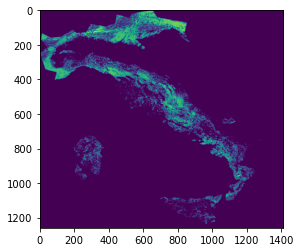

In [249]:
plt.imshow(maskData[0,:,:])

#### 2. POIs and subnational borders

In [68]:
%%time
ITA_hospitals = ox.pois.pois_from_place('Italy',{'amenity':'hospital'})  # get the POIs from OpenStreetMap

CPU times: user 6min 44s, sys: 1.39 s, total: 6min 45s
Wall time: 55min 53s


In [71]:
ITA_hospitals.to_csv(data+'/energy/italy_hospitals.csv')   # save for re-use

/home/nicholasjones/miniconda3/envs/GPD3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
ITA_hospitals.shape  # check number of POIs downloaded

(2302, 155)

In [229]:
# reload and clean POIs from csv

ITA_hospitals = pd.read_csv(data+'/energy/italy_hospitals.csv',index_col=0)
ITA_hospitals['geometry'] = ITA_hospitals['geometry'].apply(wkt.loads)

crs = {'init': 'epsg:2263'} #http://www.spatialreference.org/ref/epsg/2263/
ITA_hospitals = gpd.GeoDataFrame(ITA_hospitals, crs=crs, geometry='geometry')

point_mask = [item.type == 'Point' for item in ITA_hospitals.geometry]
ITA_hospitals = ITA_hospitals[point_mask]

<AxesSubplot:>

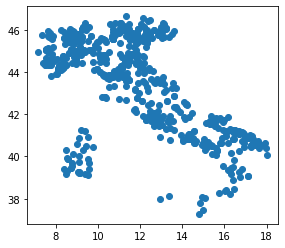

In [230]:
ITA_hospitals.plot()

In [231]:
ITA_hospitals.head()

name  \
1          Distretto di salute mentale A.S.L. Roma D   
2  Pronto Soccorso Ospadale "Giovanni Battista Gr...   
3                             ASL di Casal Bernocchi   
6                                     POSTAZIONE 118   
7               Pronto Soccorso Ospedale "San Paolo"   

                    geometry  
1  POINT (12.27079 41.73250)  
2  POINT (12.29928 41.72920)  
3  POINT (12.38049 41.78443)  
6  POINT (12.12696 41.93334)  
7  POINT (11.80920 42.09795)

In [232]:
# load boundaries from GADM dataset

boundaries = gpd.read_file(data+'/GADM/GADM_IT/gadm36_ITA_1.shp')[['NAME_1','geometry']]
boundaries.rename(columns={'NAME_1':'region'},inplace=True)

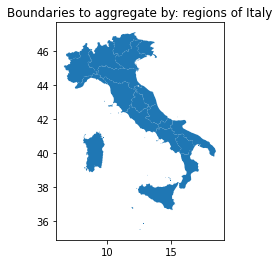

In [233]:
boundaries.plot()
plt.title('Boundaries to aggregate by: regions of Italy');

#### 3. Landslide risk query

In [234]:
ITA_hospitals['landslide_prob'] = point_query(ITA_hospitals, landslide_pth)  # sample the raster at each POI location

In [235]:
ITA_hospitals.landslide_prob.fillna(0,inplace=True)   # fill NA values with zero

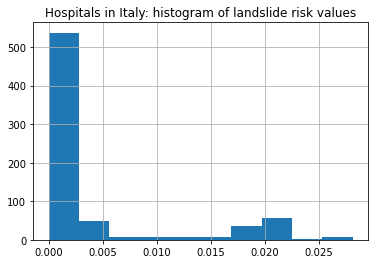

In [236]:
ITA_hospitals.landslide_prob.hist()
plt.title('Hospitals in Italy: histogram of landslide risk values');    # Histogram could also be done region-wise

In [237]:
ITA_hospitals = gpd.sjoin(ITA_hospitals,boundaries)    # spatial join POIs with boundaries
ITA_hospitals.drop(columns=['index_right'],inplace=True)

In [238]:
# mean landslide risk at hospitals in each region (other summary stats also possible)
mean_landslide_prob = ITA_hospitals.groupby('region').mean().sort_values(by='landslide_prob',ascending=False)
mean_landslide_prob.head()   

landslide_prob
region                             
Molise                     0.017797
Valle d'Aosta              0.014049
Trentino-Alto Adige        0.012250
Marche                     0.010305
Calabria                   0.008373

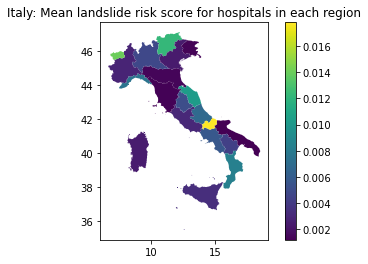

In [239]:
# join back with boundaries and visualize mean values
boundaries = boundaries.merge(mean_landslide_prob,left_on='region',right_on = mean_landslide_prob.index)
boundaries.rename(columns = {'landslide_prob':'mean_landslide_prob_at_hospitals'},inplace=True)
boundaries.plot(column = 'mean_landslide_prob_at_hospitals',legend=True)
plt.title('Italy: Mean landslide risk score for hospitals in each region');

In [241]:
# another way to summarize
ITA_hospitals['non-zero_risk'] = ITA_hospitals.landslide_prob > 0
ITA_hospitals['non-zero_risk'] = ITA_hospitals['non-zero_risk'].astype(int)

ITA_hospitals['risk_10_percent_plus'] = ITA_hospitals.landslide_prob > 0.01
ITA_hospitals['risk_10_percent_plus'] = ITA_hospitals['risk_10_percent_plus'].astype(int)

ITA_hospitals['risk_20_percent_plus'] = ITA_hospitals.landslide_prob > 0.02
ITA_hospitals['risk_20_percent_plus'] = ITA_hospitals['risk_20_percent_plus'].astype(int)

In [242]:
print('{:.1f}% of hospitals in Italy have non-zero landslide risk'.format(
    ITA_hospitals['non-zero_risk'].mean() * 100))

print('{:.1f}% of hospitals in Italy have landslide risk above 10%'.format(
    ITA_hospitals['risk_10_percent_plus'].mean() * 100))

print('{:.1f}% of hospitals in Italy have landslide risk above 20%'.format(
    ITA_hospitals['risk_20_percent_plus'].mean() * 100))


24.9% of hospitals in Italy have non-zero landslide risk
17.2% of hospitals in Italy have landslide risk above 10%
8.0% of hospitals in Italy have landslide risk above 20%


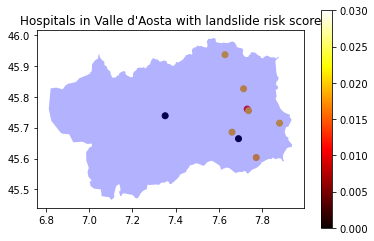

In [243]:
f,ax = plt.subplots()
ITA_hospitals[ITA_hospitals.region == "Valle d'Aosta"].plot(ax = ax,column = 'landslide_prob',legend=True,cmap='hot',vmax=0.03)
boundaries[boundaries.region == "Valle d'Aosta"].plot(facecolor='b',alpha=0.3,ax=ax)
plt.title("Hospitals in Valle d'Aosta with landslide risk score");

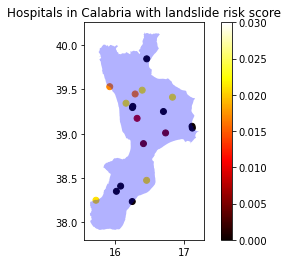

In [244]:
f,ax = plt.subplots()
ITA_hospitals[ITA_hospitals.region == "Calabria"].plot(ax = ax,column = 'landslide_prob',legend=True,cmap='hot',vmax=0.03)
boundaries[boundaries.region == "Calabria"].plot(facecolor='b',alpha=0.3,ax=ax)
plt.title("Hospitals in Calabria with landslide risk score");